# 491 -A4

 ## E1 & E2

### EM Algorithm 

E-step
$$p(i|x^n) = \frac{p(i)exp\{-\frac{1}{2}(x^n-m_i)^TS_i^{-1}(x^n-m_i)\}det(S_i)^{-\frac{1}{2}}}{\sum_{i'}p(i')exp\{-\frac{1}{2}(x^n-m_{i'})^TS_{i'}^{-1}(x^n-m_{i'})\}det(S_{i'})^{-\frac{1}{2}}}$$  
  
  
M-step

Mean:

$$\sum_{n=1}^{N}\sum_{i=1}^{H} p^{old}(i|x^n)(x^n-m_i)^TS_i^{-1}(x^n-m_i)$$

$$m_i^{new} = \sum^N_{n=1}p^{old}(n|i)x^n$$

In [1]:
import csv, copy, gzip, pickle
 
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chi2

%matplotlib inline

In [2]:
with open('data/faithful.txt', 'rt') as csvfile:
    dataReader = csv.reader(csvfile, delimiter=' ')
    # initialize an empty array
    data = []
    for row in dataReader:
        data.append(np.array(row).astype(np.float))
    # convert data into a numpy array
    data = np.asarray(data)

In [3]:
ngmm = 2 # quantity of Gaussian Mixture Model

mu = np.asarray([[2, 70], 
                 [4, 80]]
               ).astype('float')

sigma = np.asarray([[[1, 0], 
                     [0, 3]], 
                    [[0.5, 0.2], 
                     [0.2, 0.6]]]
                  ).astype('float')

In [4]:
def covmatIsLegal(sigma):
    for covmat in sigma:
        if not(np.allclose(covmat, covmat.T)) or np.any(np.linalg.eigvals(covmat) <= 0):
            return False
    return True

print("Convariance Matrices are Legal? : %r" % covmatIsLegal(sigma))

Convariance Matrices are Legal? : True


In [5]:
gmm = [{'mean': mu[m], 'covariance': sigma[m], 'prior': 1.0/ngmm} for m in range(ngmm)]

In [6]:
def plotGaussianModel2D(mu, sigma, pltopt='k'):
    if sigma.any():
        # calculate ellipse constants
        c = chi2.ppf(0.9, 2) # use confidence interval 0.9
        # get eigen vector and eigen values
        eigenValue, eigenVector = np.linalg.eig(sigma)
        # calculate points on ellipse
        t = np.linspace(0, 2*np.pi, 100) # draw 100 points
        u = [np.cos(t), np.sin(t)]
        w = c * eigenVector.dot(np.diag(np.sqrt(eigenValue)).dot(u))
        z = w.T + mu
    else:
        z = mu
    # plot ellipse by connecting sample points on curve
    plt.plot(z[:,0], z[:,1], pltopt)
    
def colorPicker(index):
    colors = 'rgbcmyk'
    return colors[np.remainder(index, len(colors))]

def gmmplot(data, gmm):
    # plot data points
    plt.scatter(data[:, 0], data[:, 1], s=4)
    # plot Gaussian model
    color = 'rgb'
    for index, model in enumerate(gmm):
        plotGaussianModel2D(model['mean'], model['covariance'], colorPicker(index))

In [7]:
# expectation
def expectation(data,gmm):
    gnum = len(gmm)
    data_n = data.shape[0]
    posterior1 = np.zeros((data_n,gnum))
    posterior2 = np.zeros((data_n,gnum))
    for i in range(data_n):
        for j in range(gnum):
            prior = np.array(gmm[j]['prior'])
            mean = np.array(gmm[j]['mean'])
            mean = mean.reshape(1,mean.shape[0])
            covariance = np.array(gmm[j]['covariance'])
            covariance = covariance.reshape(covariance.shape[0],covariance.shape[1])
            data1 = np.array(data[i])
            data1 = data1.reshape(1,data1.shape[0])
            different = data1 - mean 
            temp1 = np.dot(different,(np.linalg.inv(covariance)))
            temp2 = np.dot(temp1,(different.T))
            temp3 = np.exp(-0.5*temp2)
            s = np.linalg.det(covariance)**(-0.5)
            e = prior * temp3 * s 
            posterior1[i,j] = e
        sum1 = sum(posterior1[i,:])
        for k in range (gnum):
            posterior2[i,k] = posterior1[i,k]/sum1
    return posterior2


# normalize_model
def normalize_model(posterior,data_n,gnum):
    posterior3 = np.zeros((data_n,gnum))
    data_n = posterior.shape[0]
    gmum = posterior.shape[1]
    sum2 = np.zeros(gnum)
    for column in range (gnum):
        sum2[column] = sum(posterior[:,column])
    for m in range(data_n):
        for n in range(gnum):
            posterior3[m,n] = posterior[m,n]/sum2[n]
    return posterior3 


# maximization_mean
def maximization_mean(posterior, data, gmm):
    data_n = posterior.shape[0]
    gnum = posterior.shape[1]
    newmean = np.zeros((gnum,data.shape[1]))
    posterior3 = normalize_model(posterior,data_n,gnum)
    for g in range (gnum):
        for n in range (data_n):
            newmean[g] += posterior3[n][g] * data[n]
        gmm[g]['mean'] = newmean[g]
    return gmm


#maximization
def maximization(posterior, data, gmm):
    data_n = posterior.shape[0]
    gnum = posterior.shape[1]
    newmean = np.zeros((gnum,data.shape[1]))
    newcovariance = np.zeros((gnum,data.shape[1],data.shape[1]))
    newprior = np.zeros((gnum))
    posterior3 = normalize_model(posterior,data_n,gnum)
    for g in range (gnum):
        for n in range (data_n):
            newmean[g] += posterior3[n,g] * data[n]
            different = data[n] - gmmcp[g]['mean']
            different = different.reshape(1,data.shape[1])
            temp1 = posterior3[n][g] * (different.T)
            temp1 = temp1.reshape(data.shape[1],1)
            temp2 = np.dot(temp1,different)
            newcovariance[g] += temp2
            #newcovariance[g] += np.dot(posterior3[n][g],(data[n] - gmmcp[g]['mean'])*np.transpose([(data[n] - gmmcp[g]['mean'])]))
            newprior[g] += posterior[n][g]
        gmm[g]['mean'] = newmean[g]
        gmm[g]['covariance'] = newcovariance[g]
        gmm[g]['prior'] = newprior[g]/data_n
    return gmm 

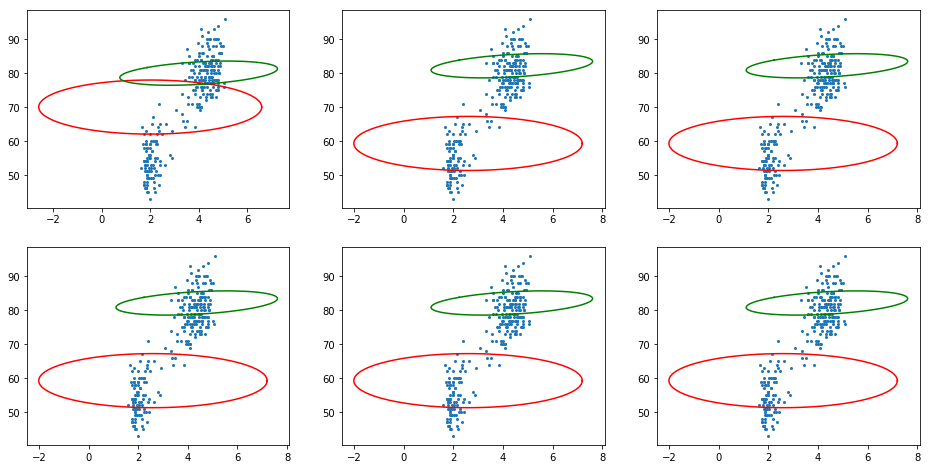

In [8]:
# make a true copy of our model
gmmcp = copy.deepcopy(gmm)

# create figure
plt.figure(figsize=(16, 8))
# improve model with EM-Algorithm
for i in range(5):
    # plot current status
    plt.subplot(231 + i)
    gmmplot(data, gmmcp)
    # excute EM-Algorithm
    for j in range(5):
        posterior = expectation(data, gmmcp)
        gmmcp = maximization_mean(posterior, data, gmmcp)
# plot final status
plt.subplot(236)
gmmplot(data,gmmcp)

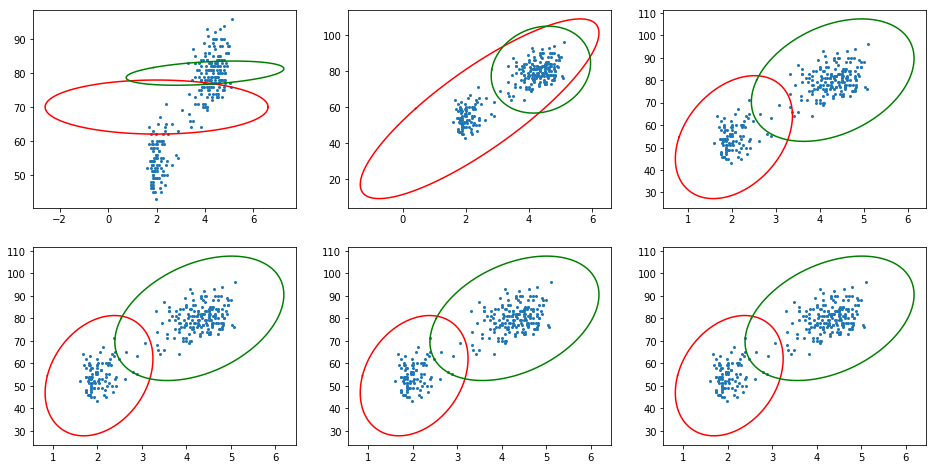

In [9]:
# make a true copy of our model
gmmcp = copy.deepcopy(gmm)

# create figure
plt.figure(figsize=(16, 8))
# improve model with EM-Algorithm
for i in range(5):
    # plot current status
    plt.subplot(231 + i)
    gmmplot(data, gmmcp)
    # excute EM-Algorithm
    for j in range(5):
        posterior = expectation(data, gmmcp)
        gmmcp = maximization(posterior, data, gmmcp)
# plot final status
plt.subplot(236)
gmmplot(data,gmmcp)

Now, I will use four gasussian model.  
The initial value I set randomly. 

In [10]:
ngmm = 4 # quantity of Gaussian Mixture Model

mu = np.asarray([[2, 70], 
                 [4, 80],
                 [6, 90],
                 [-4, 60]]
               ).astype('float')

sigma = np.asarray([[[1, 0], 
                     [0, 3]], 
                    [[0.5, 0.2], 
                     [0.2, 0.6]],
                    [[0.1, 0],
                     [0, 0.4]],
                    [[1.6, 0.5],
                     [0.5, 0.8]]]
                  ).astype('float')

In [11]:
def covmatIsLegal(sigma):
    for covmat in sigma:
        if not(np.allclose(covmat, covmat.T)) or np.any(np.linalg.eigvals(covmat) <= 0):
            return False
    return True

print("Convariance Matrices are Legal? : %r" % covmatIsLegal(sigma))

Convariance Matrices are Legal? : True


In [12]:
gmm2 = [{'mean': mu[m], 'covariance': sigma[m], 'prior': 1.0/ngmm} for m in range(ngmm)]

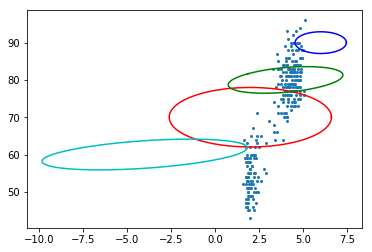

In [13]:
gmmplot(data, gmm2)

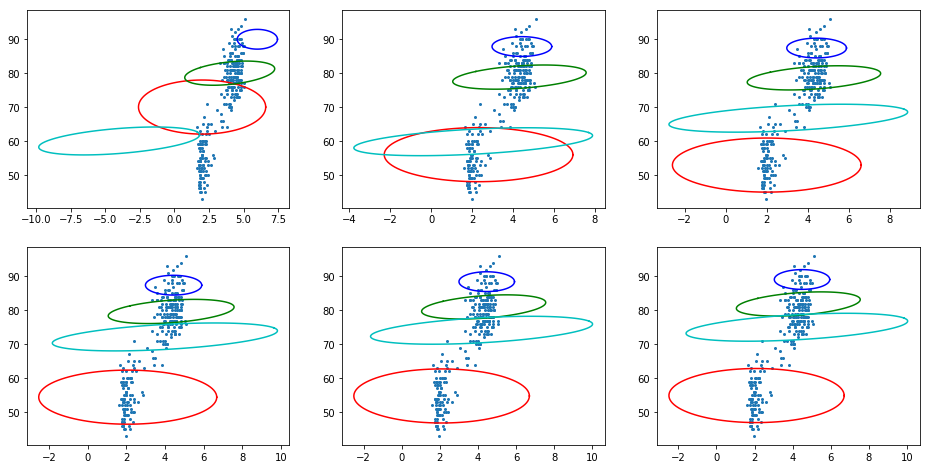

In [14]:
# make a true copy of our model
gmmcp = copy.deepcopy(gmm2)

# create figure
plt.figure(figsize=(16, 8))
# improve model with EM-Algorithm
for i in range(5):
    # plot current status
    plt.subplot(231 + i)
    gmmplot(data, gmmcp)
    # excute EM-Algorithm
    for j in range(5):
        posterior = expectation(data, gmmcp)
        gmmcp = maximization_mean(posterior, data, gmmcp)
# plot final status
plt.subplot(236)
gmmplot(data,gmmcp)

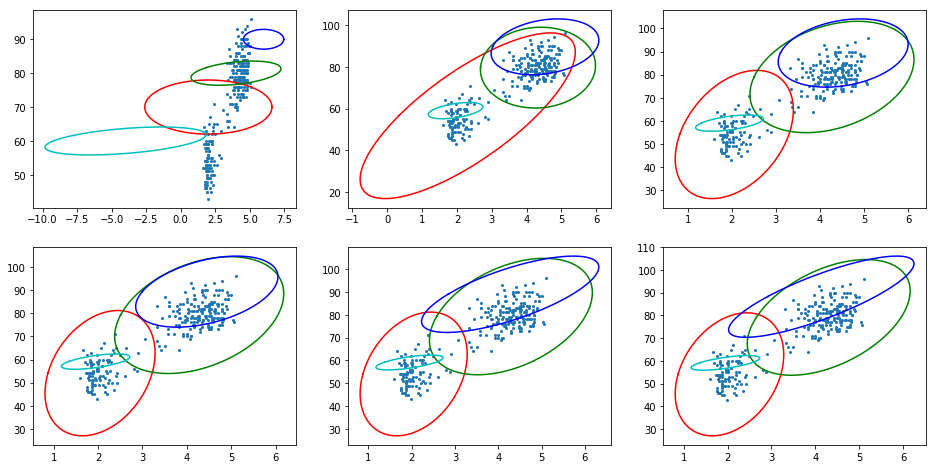

In [15]:
# make a true copy of our model
gmmcp = copy.deepcopy(gmm2)

# create figure
plt.figure(figsize=(16, 8))
# improve model with EM-Algorithm
for i in range(5):
    # plot current status
    plt.subplot(231 + i)
    gmmplot(data, gmmcp)
    # excute EM-Algorithm
    for j in range(5):
        posterior = expectation(data, gmmcp)
        gmmcp = maximization(posterior, data, gmmcp)
# plot final status
plt.subplot(236)
gmmplot(data,gmmcp)

I think the initial value and position is very importent.  
If the initial position is close to the data, it will cluster quickly. And the initial value will decide how quickly the size will be appropriate to the data. 

## E3 

In [16]:
with gzip.open('data/mnist.pkl.gz', 'rb') as f:
    f = pickle._Unpickler(f)
    f.encoding = 'latin1'
    trainSet, validSet, testSet = f.load()
    mnistData = np.concatenate((trainSet[0], validSet[0], testSet[0]), axis=0)
    mnistlabel = np.concatenate((trainSet[1], validSet[1], testSet[1]), axis=0)

In [17]:
def showImageSamples(imageset, n, shape=[28,28], col=3, width=16, dispopt='gray', random=True):
    row    = np.ceil(n / col)
    height = np.around(row * (width / col))
    plt.figure(figsize=(width, height))
    subplotIndex = 100 * row + 10 * col + 1
    for i in range(n):
        if random:
            img = imageset[np.random.randint(len(imageset), size=1)]
        else:
            img = imageset[i]
        plt.subplot(subplotIndex + i)
        plt.imshow(img.reshape(shape), cmap=dispopt)

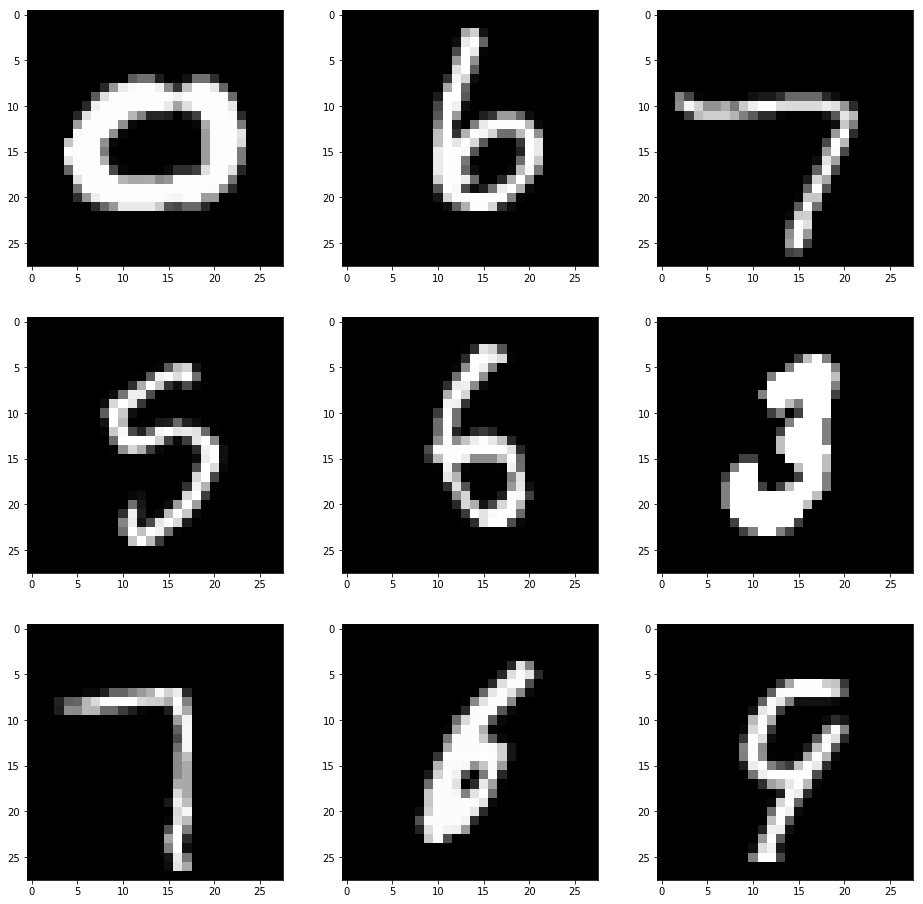

In [18]:
showImageSamples(mnistData, 9)

I will write a PCA function by hand. 

In [19]:
def dimReducePCA(mnistData,dimension):
    # centralize data, using data minus data's mean  
    mean_vals = mnistData.mean(axis=0)
    mean_removed = mnistData - mean_vals
    # Find covariance matrix
    cov_mat = np.cov(mean_removed, rowvar=0)
    # Find eigenvalues and eigenvectors
    eig_vals, eig_vects = np.linalg.eig(np.mat(cov_mat))
    eig_val_index = np.argsort(eig_vals)
    eig_val_index = eig_val_index[:-(dimension + 1) : -1]
    reg_eig_vects = eig_vects[:, eig_val_index] 
    # Transfor data into new space 
    low_d_data_mat = mean_removed * reg_eig_vects
    recon_mat = (low_d_data_mat * reg_eig_vects.T) + mean_vals
    
    eigenVectors = eig_vects.real
    eigenValues = eig_vals.real 
    
    mnistData2D = np.array(low_d_data_mat.real.astype('float'))
    return mnistData2D, eigenVectors, eigenValues

In [20]:
mnistData2D, eigenVectors, eigenValues = dimReducePCA(mnistData,2)

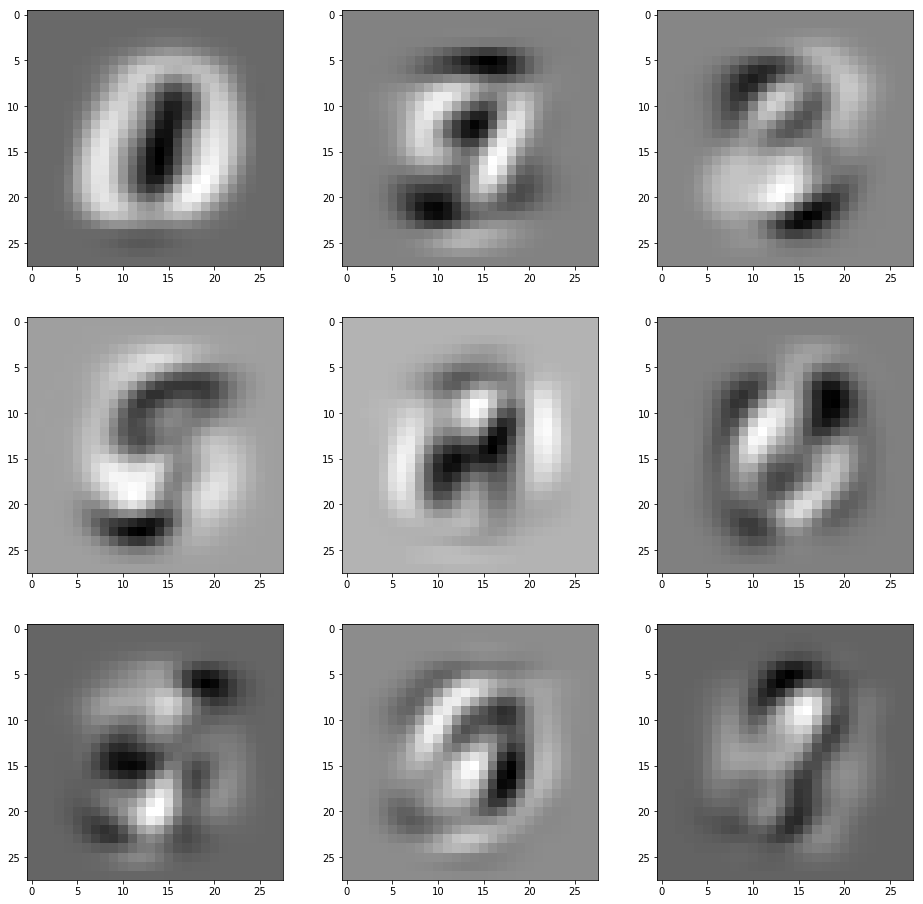

In [21]:
showImageSamples(eigenVectors.T, 9, random=False)

Scatter plot 

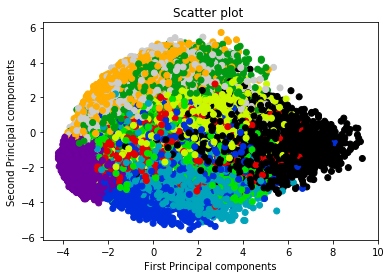

In [22]:
plt.scatter(mnistData2D[:, 0], mnistData2D[:, 1], c=mnistlabel, cmap=plt.cm.nipy_spectral)
plt.title('Scatter plot ')
plt.xlabel('First Principal components')
plt.ylabel('Second Principal components')
plt.show()

Using built-in PCA function to show the scatter plot 

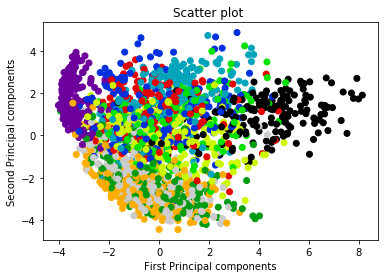

In [23]:
from sklearn.decomposition import PCA  
mnistData1 = mnistData[1:2000]
mnistlabel1 = mnistlabel[1:2000] 
pca = PCA(n_components=2)
X = pca.fit_transform(mnistData1)
plt.scatter(X[:, 0], X[:, 1], c=mnistlabel1, cmap=plt.cm.nipy_spectral)
plt.title('Scatter plot ')
plt.xlabel('First Principal components')
plt.ylabel('Second Principal components')
plt.show()

I will show the 3 dimension scatter plot:

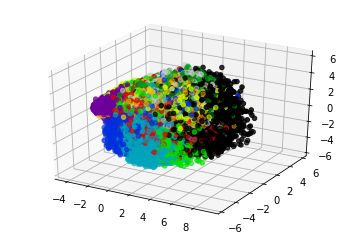

In [24]:
pca = PCA(n_components=3)
pca.fit(mnistData)
A = pca.transform(mnistData)
from mpl_toolkits.mplot3d import Axes3D
ax = plt.figure().gca(projection = '3d')  
ax.scatter(A[:, 0], A[:, 1], A[:, 2], c=mnistlabel, cmap=plt.cm.nipy_spectral)

## E4

Firstly, I will use 2D data.

In [25]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import ortho_group
import matplotlib.pyplot as plt 

In [26]:
def randinitMean(n, drange):
    mu = []
    for m in range(n):
        mu.append([np.random.uniform(drange[i]['MIN'], drange[i]['MAX']) for i in range(len(drange))])
    return np.asarray(mu)

def randinitCovariance2D(n):
    sigma = []
    for m in range(n):
        # randomly pick a direction
        angle = np.random.uniform(0, 2 * np.pi)
        # create eigen vector with the direction and direction orthogonal to it
        eigenVector = np.asarray([[np.cos(angle), np.sin(angle)],
                                  [np.cos(angle + np.pi/2), np.sin(angle + np.pi/2)]])
        # randomly generate eigen values
        eigenValue = abs(np.random.normal(size=2))
        # compose covariance matrix
        sigma.append(eigenVector.T.dot(np.diag(eigenValue).dot(eigenVector)))
    # return in form of numpy.ndarray
    return np.asarray(sigma)

def randinitCovariance(n):
    sigma = []
    for m in range(n):
        #generate 3x3 orthogonal matrix for 3D Gaussian model as your eigen vectors
        eigenVector = ortho_group.rvs(3)
        eigenValue = abs(np.random.normal(size=3))
        sigma.append(eigenVector.T.dot(np.diag(eigenValue).dot(eigenVector)))
    return np.asarray(sigma)

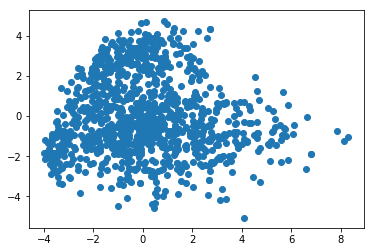

In [27]:
ndata = 1000
# randomly pick a subset of data
data = mnistData2D[np.random.randint(len(mnistData2D), size=ndata)]
plt.scatter(data[:, 0], data[:, 1],cmap=plt.cm.nipy_spectral)
plt.show()

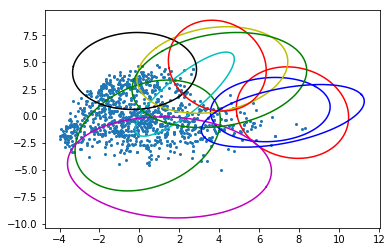

In [28]:
ngmm = 10

# get information of range on each dimension
dataRange = []
for i in range(data.shape[1]):
    dataRange.append({'MIN': min(data[:,i]), 'MAX': max(data[:,i])})
    
# randomly initialize Gaussian mixture model
mu    = randinitMean(ngmm, dataRange)
sigma = randinitCovariance2D(ngmm)
gmm   = [{'mean': mu[m], 'covariance': sigma[m], 'prior': 1.0/ngmm} for m in range(ngmm)]

# show initial state
gmmplot(data, gmm)

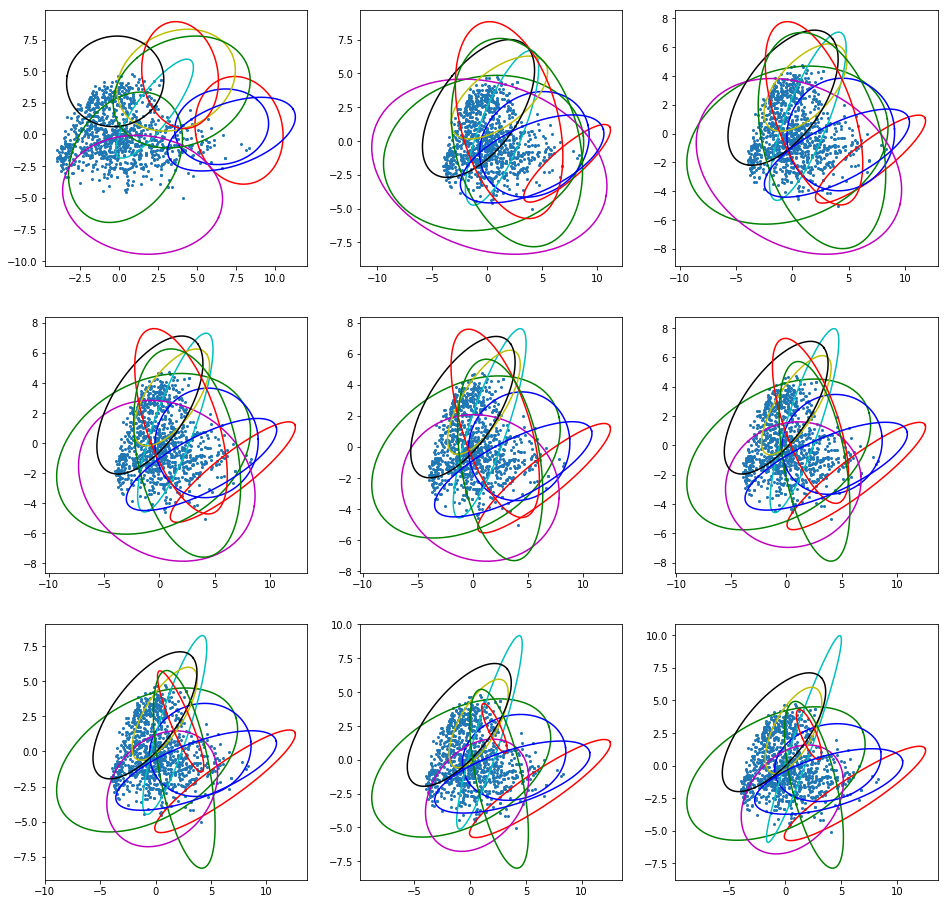

In [29]:
gmmcp = copy.deepcopy(gmm)

# create figure
plt.figure(figsize=(16, 16))
# improve model with EM-Algorithm
for i in range(8):
    # plot current status
    plt.subplot(331 + i)
    gmmplot(data, gmmcp)
    # excute EM-Algorithm
    for j in range(5):
        posterior = expectation(data, gmmcp)
        gmmcp = maximization(posterior, data, gmmcp)
# plot final status
plt.subplot(339)
gmmplot(data,gmmcp)

Now, I will use 3D data. 

<Figure size 1440x720 with 0 Axes>

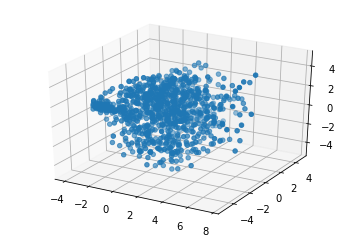

In [30]:
pca = PCA(n_components=3)  
mnistData3D = pca.fit_transform(mnistData)

ndata = 1000
data = mnistData3D[np.random.randint(len(mnistData3D), size=ndata)]
fig = plt.figure()
fig.set_size_inches(20,10)
ax = plt.figure().gca(projection = '3d')  
ax.scatter(data[:, 0], data[:, 1], data[:, 2], cmap=plt.cm.nipy_spectral)

In [37]:
# draw Gaussian 3D Model
def plotGaussianModel3D(mu,sigma,ax,pltopt = 'k'):   
    U, E, V = np.linalg.svd(sigma)
    u = np.linspace(0.0, 2.0 * np.pi, 100)
    v = np.linspace(0.0, 1.0 * np.pi, 100)
    x = E[0] * np.outer(np.cos(u), np.sin(v))
    y = E[1] * np.outer(np.sin(u), np.sin(v))
    z = E[2] * np.outer(np.ones_like(u), np.cos(v))
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], U) + mu
    ax.plot_wireframe(x, y, z,  rstride=6, cstride=6, color=pltopt,alpha=0.6)

In [38]:
def gmmplot3D(data,gmm):
    fig = plt.figure()
    fig.set_size_inches(12,8)
    ax = fig.add_subplot(111, projection='3d') 
    plt.set_cmap('Set1')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2],alpha=0.9, cmap=plt.cm.nipy_spectral)
    for index, model in enumerate(gmm):
        plotGaussianModel3D(model['mean'], model['covariance'],ax,colorPicker(index))

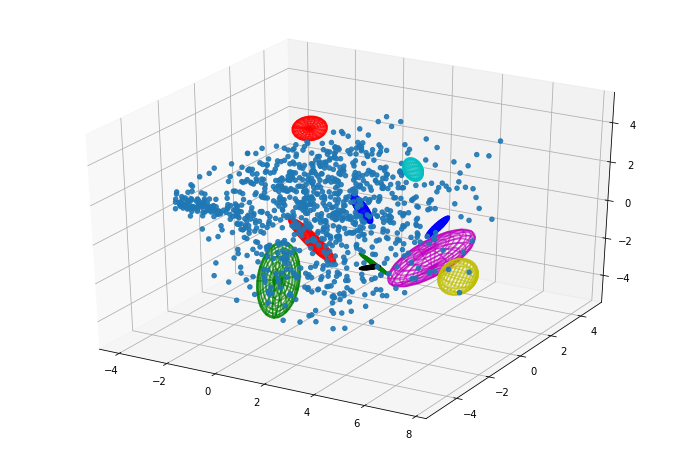

In [39]:
ngmm = 10

# get information of range on each dimension
dataRange = []
for i in range(data.shape[1]):
    dataRange.append({'MIN': min(data[:,i]), 'MAX': max(data[:,i])})
    
# randomly initialize Gaussian mixture model
mu    = randinitMean(ngmm, dataRange)
sigma = randinitCovariance(ngmm)
gmm   = [{'mean': mu[m], 'covariance': sigma[m], 'prior': 1.0/ngmm} for m in range(ngmm)]

gmmplot3D(data,gmm)

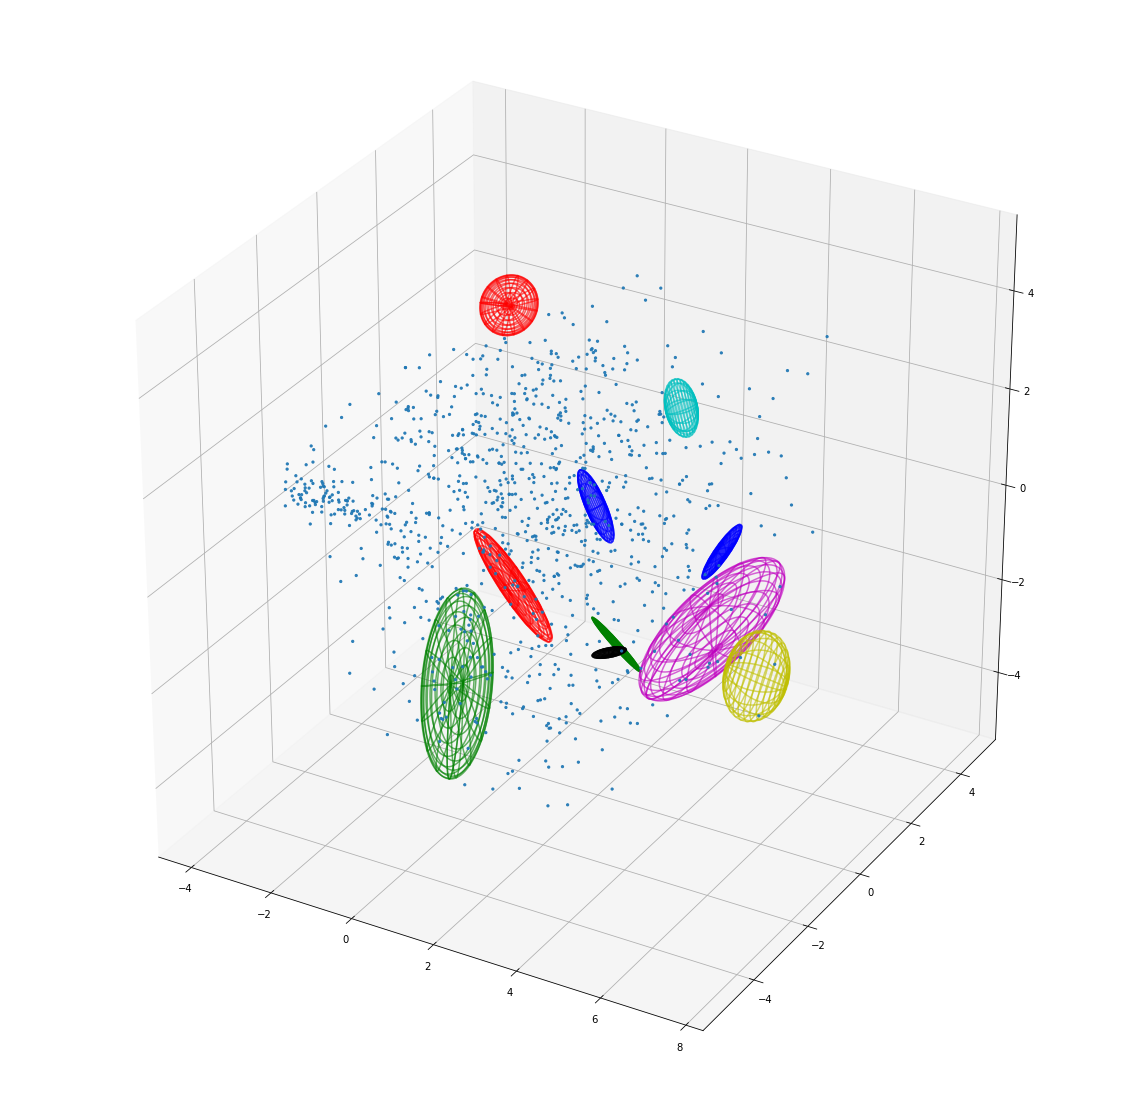

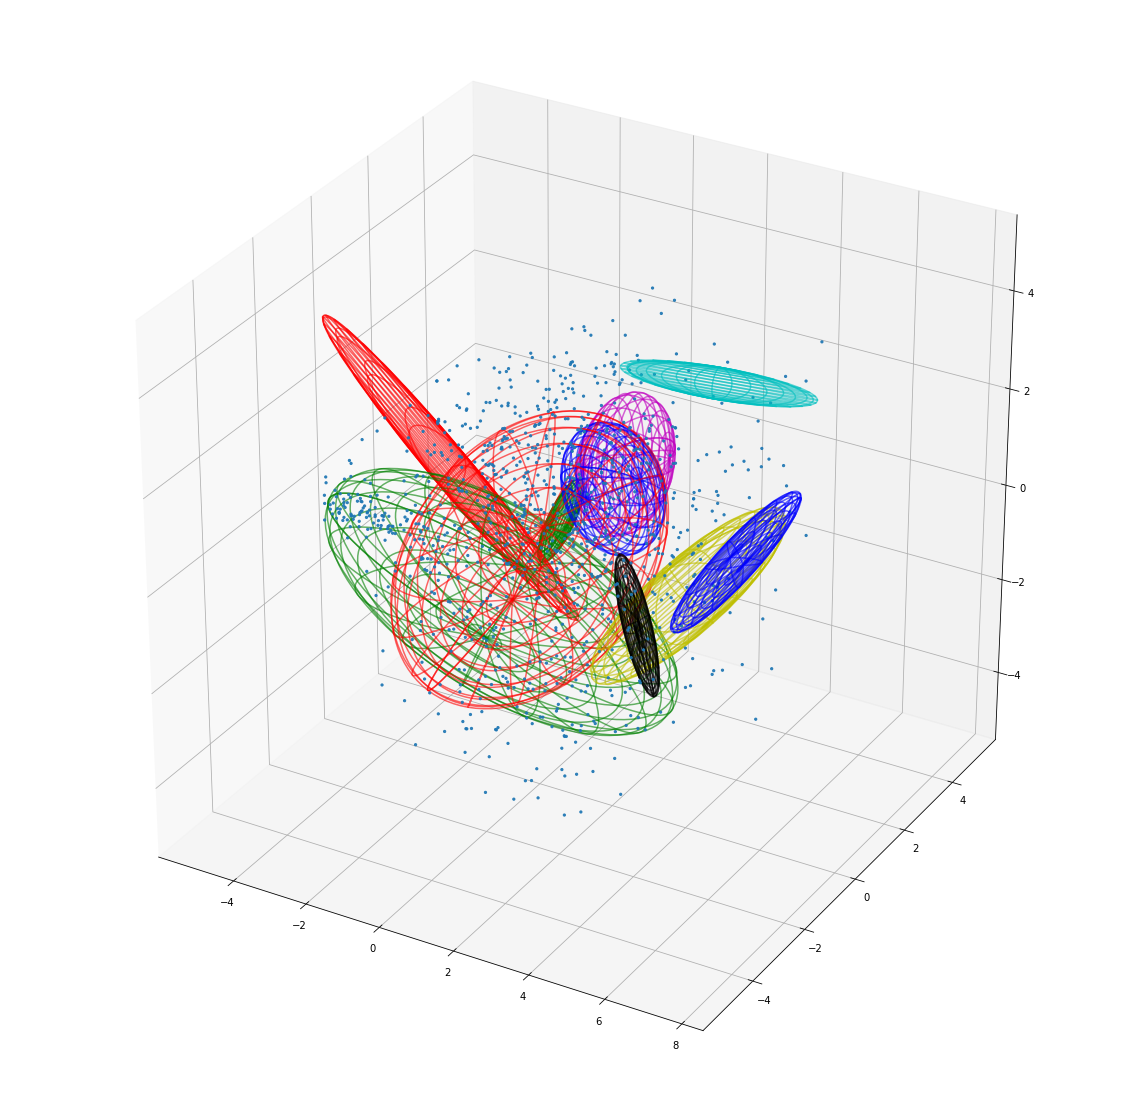

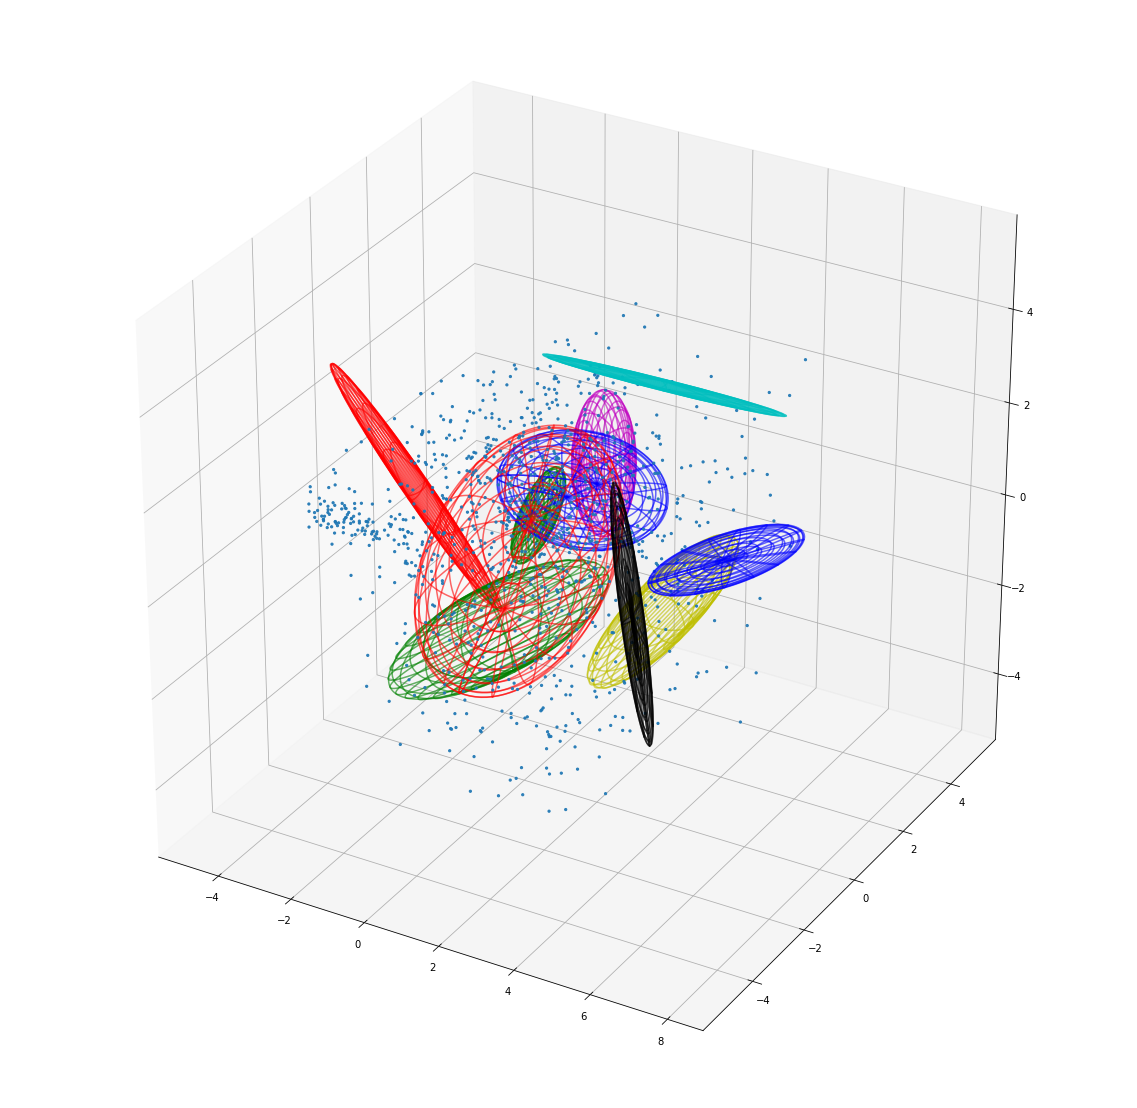

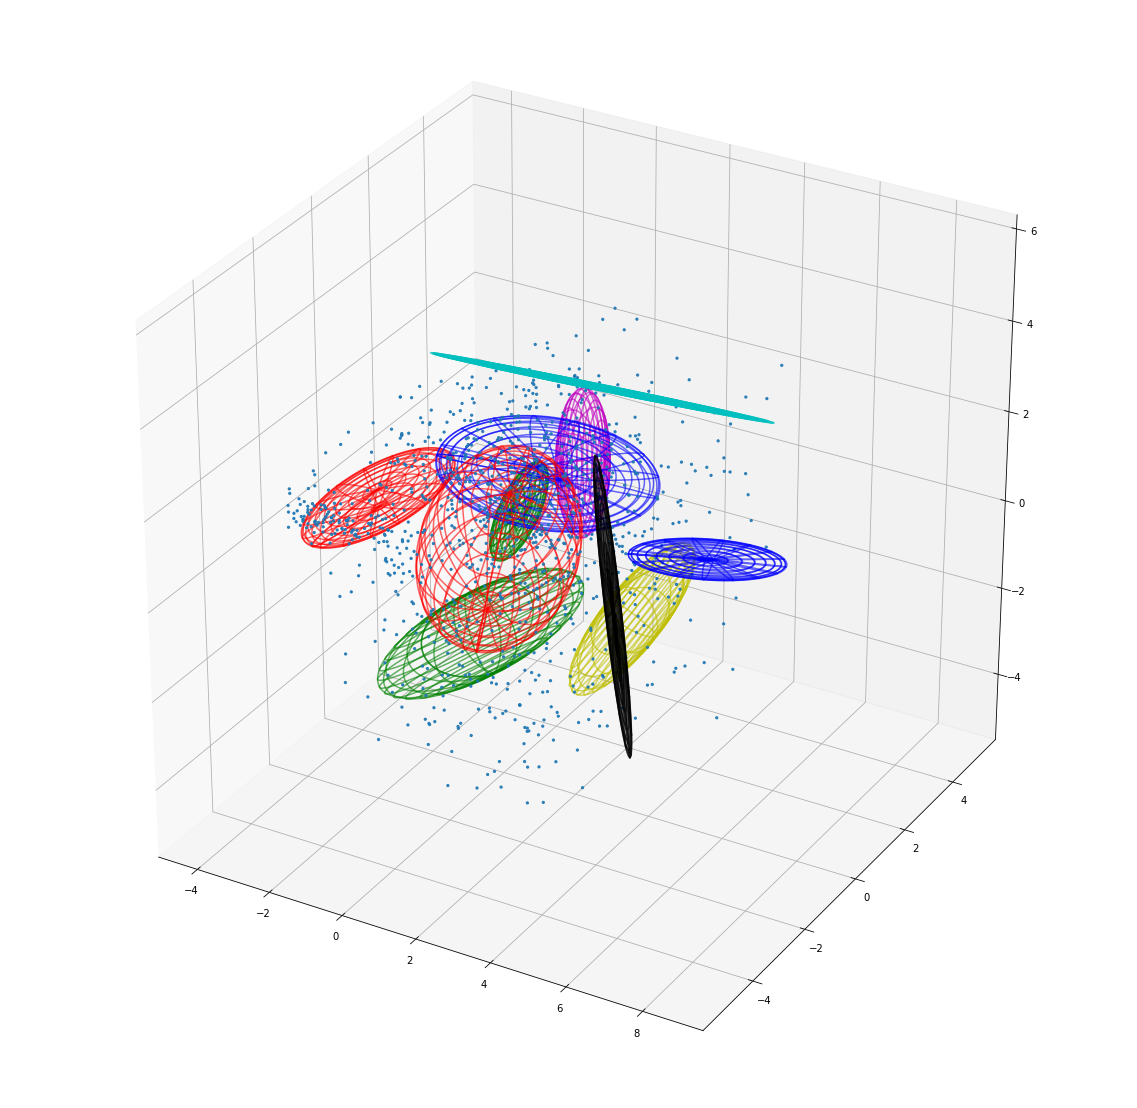

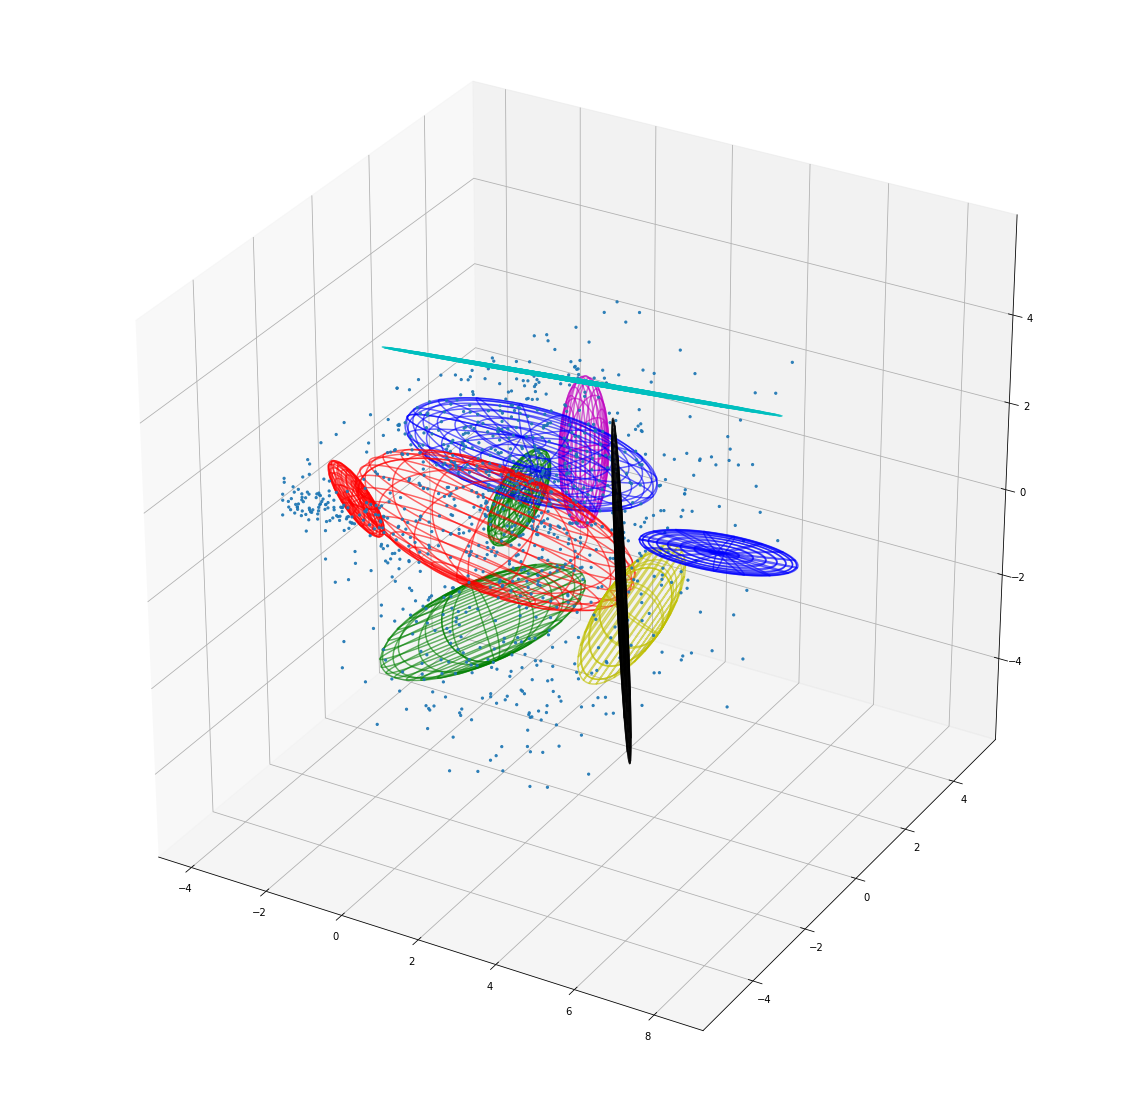

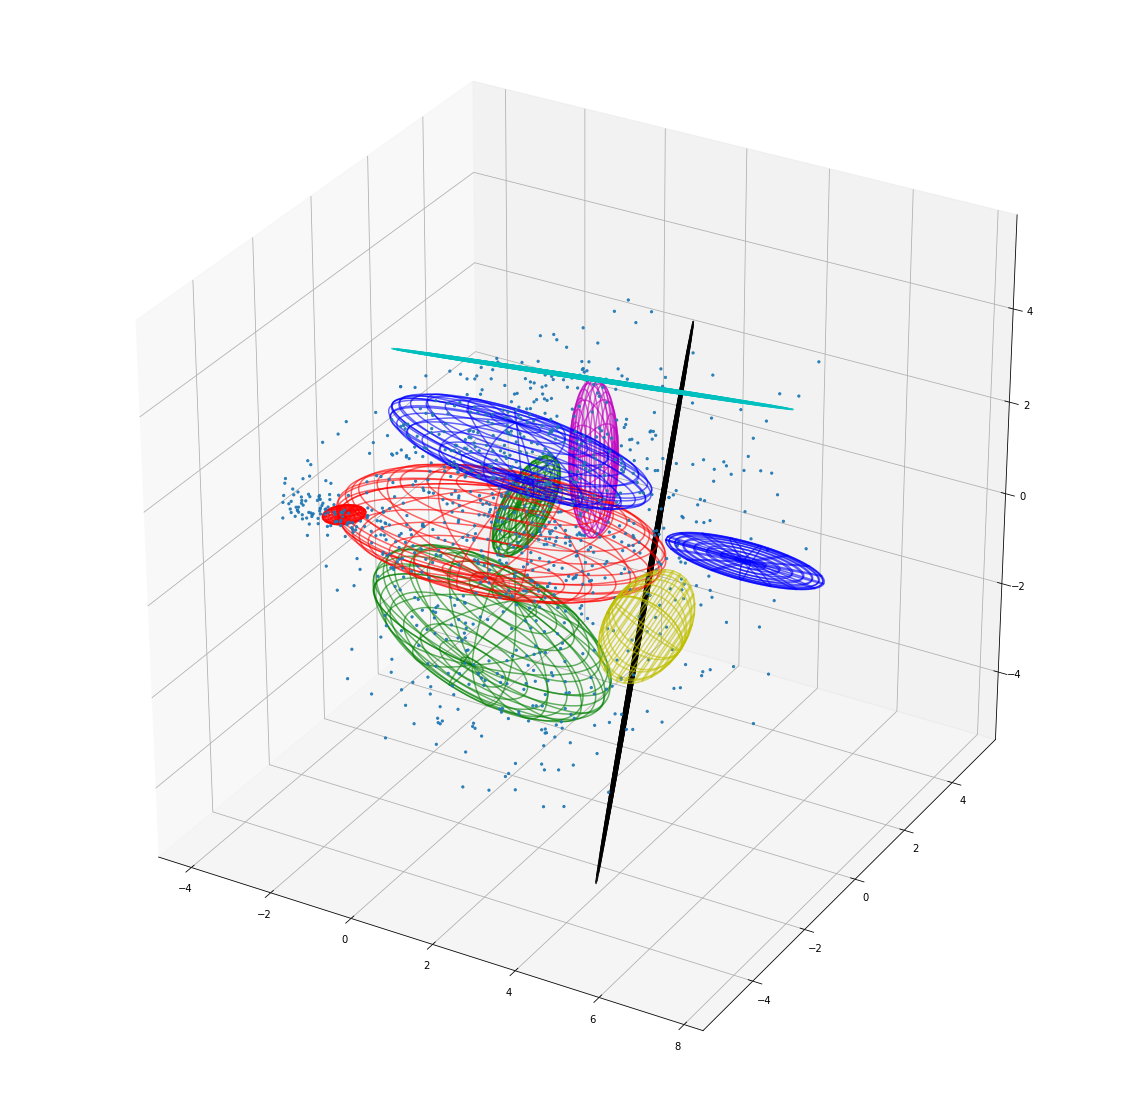

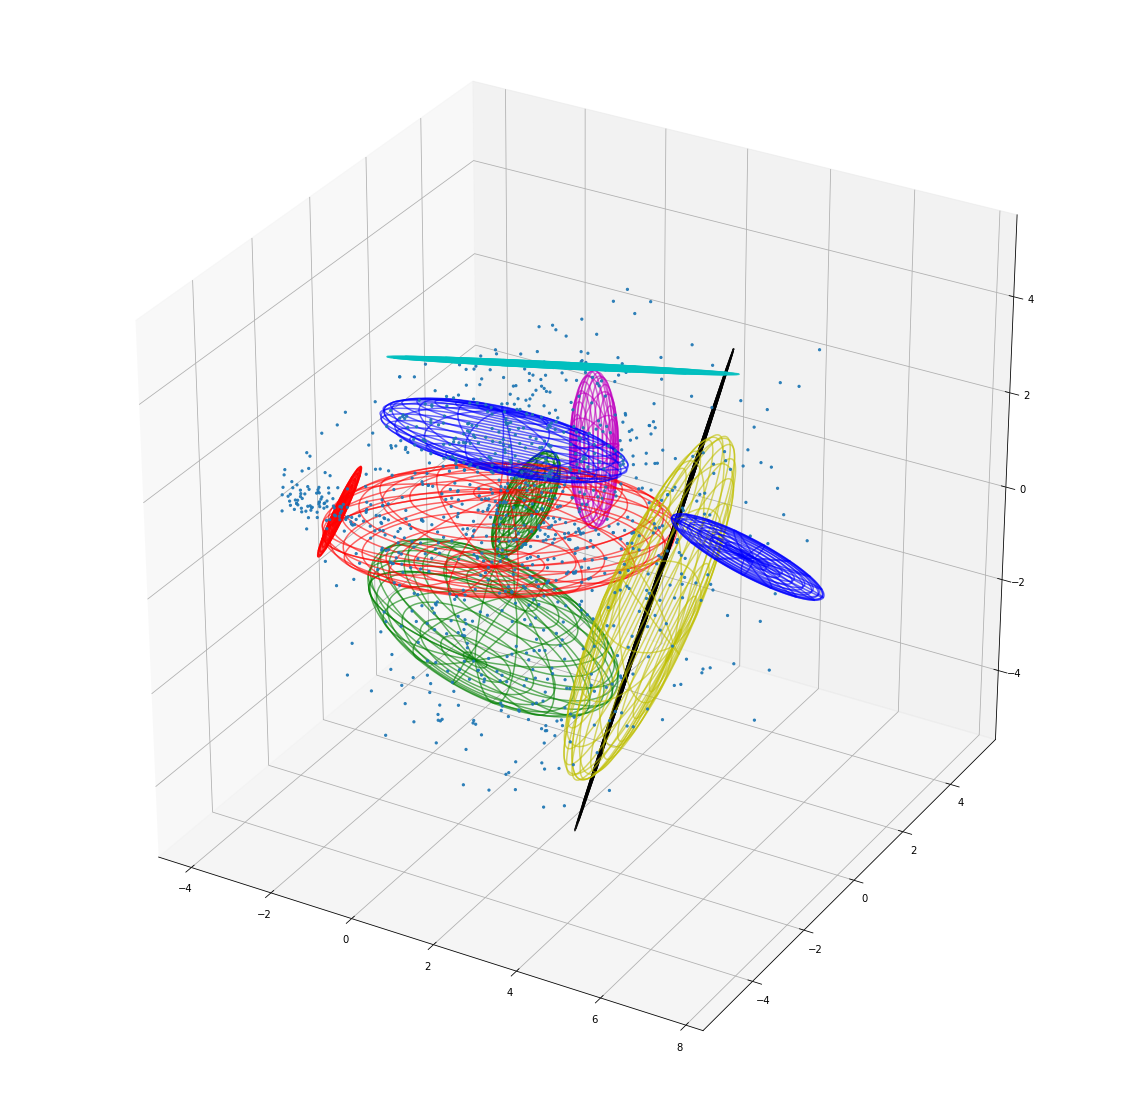

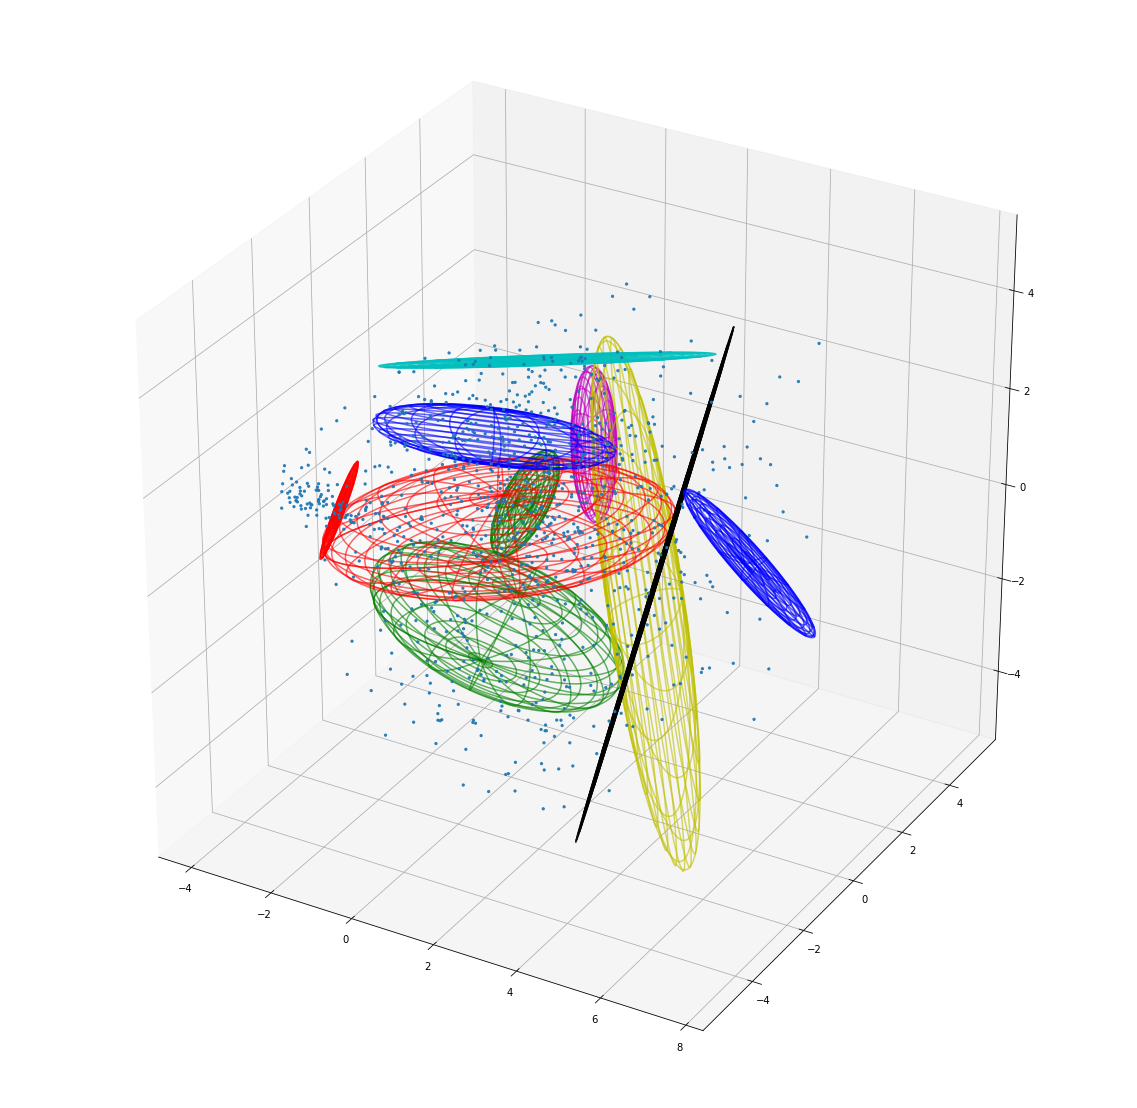

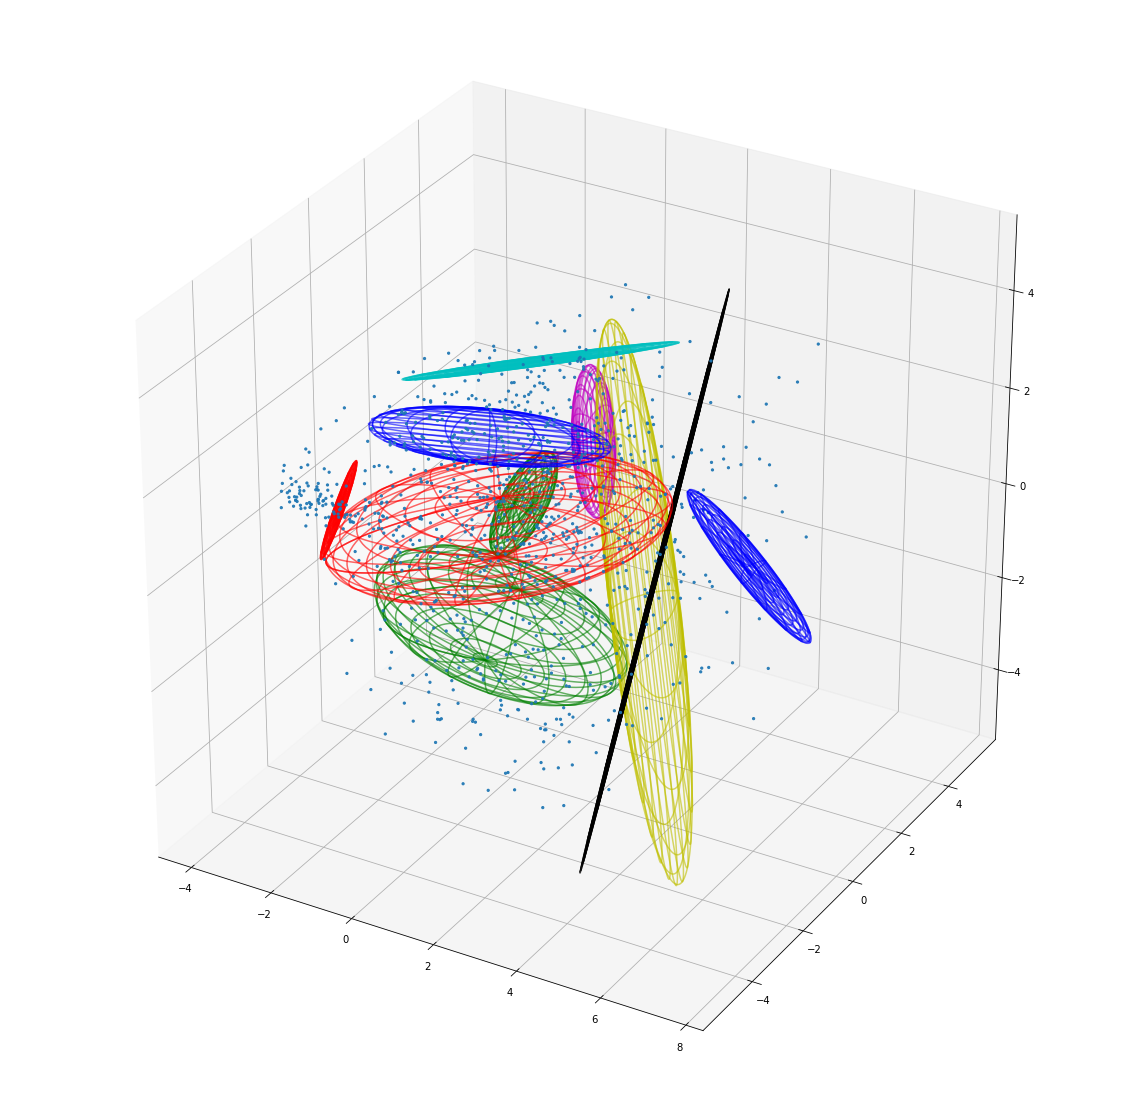

In [45]:
gmmcp = copy.deepcopy(gmm)

for i in range(9):
    fig = plt.figure(figsize=(20, 20))

    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1],data[:,2], s=5,alpha=0.9, cmap=plt.cm.nipy_spectral,norm=0.5)
    
    for index, model in enumerate(gmmcp):
        plotGaussianModel3D(model['mean'], model['covariance'],ax,colorPicker(index))

    # improve model with EM-Algorithm
    for j in range(5):
        posterior = expectation(data, gmmcp)
        gmmcp = maximization(posterior, data, gmmcp)
    

According to the results, there are some good clustering, for example, the big red ellipsoid includes many points. But there are still many points are not clusteted. 